 #  A Whale off the Port(folio)

 In this assignment, you'll get to use what you've learned this week to evaluate the performance among various algorithmic, hedge, and mutual fund portfolios and compare them against the S&P 500.

In [123]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
%matplotlib inline

# Data Cleaning

In this section, you will need to read the CSV files into DataFrames and perform any necessary data cleaning steps. After cleaning, combine all DataFrames into a single DataFrame.

Files:
1. whale_returns.csv
2. algo_returns.csv
3. sp500_history.csv

## Whale Returns

Read the Whale Portfolio daily returns and clean the data

In [124]:
# Reading whale returns
whale_returns_csv = Path("Resources/whale_returns.csv")
whale_returns = pd.read_csv(whale_returns_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)
whale_returns.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC
Date,,,,
2015-03-02,NaN,NaN,NaN,NaN
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569
2015-03-04,0.002230,0.003241,-0.002534,0.004213
2015-03-05,0.004016,0.004076,0.002355,0.006726
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098


In [125]:
# Count nulls
whale_returns.isna().sum()

SOROS FUND MANAGEMENT LLC      1
PAULSON &amp; CO.INC.              1
TIGER GLOBAL MANAGEMENT LLC    1
BERKSHIRE HATHAWAY INC         1
dtype: int64

In [126]:
# Drop nulls
whale_returns = whale_returns.dropna()
whale_returns.isna().sum()


SOROS FUND MANAGEMENT LLC      0
PAULSON &amp; CO.INC.              0
TIGER GLOBAL MANAGEMENT LLC    0
BERKSHIRE HATHAWAY INC         0
dtype: int64

## Algorithmic Daily Returns

Read the algorithmic daily returns and clean the data

In [127]:
# Reading algorithmic returns
algo_returns_csv = Path("Resources/algo_returns.csv")
algo_returns = pd.read_csv(algo_returns_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)
algo_returns.head()

,Algo 1,Algo 2
Date,,
2014-05-28,0.001745,NaN
2014-05-29,0.003978,NaN
2014-05-30,0.004464,NaN
2014-06-02,0.005692,NaN
2014-06-03,0.005292,NaN


In [128]:
# Count nulls
algo_returns.isna().sum()

Algo 1    0
Algo 2    6
dtype: int64

In [129]:
# Drop nulls
algo_returns = algo_returns.dropna()
algo_returns.isna().sum()


Algo 1    0
Algo 2    0
dtype: int64

## S&P 500 Returns

Read the S&P500 Historic Closing Prices and create a new daily returns DataFrame from the data. 

In [130]:
# Reading S&P 500 Closing Prices
sp500_history_csv = Path("Resources/sp500_history.csv")
sp500_history = pd.read_csv(sp500_history_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)
sp500_history.sort_index(inplace=True)
sp500_history.head()


,Close
Date,
2012-10-01,$1444.49
2012-10-02,$1445.75
2012-10-03,$1450.99
2012-10-04,$1461.40
2012-10-05,$1460.93


In [131]:
# Check Data Types
sp500_history.dtypes

Close    object
dtype: object

In [132]:
# Fix Data Types
sp500_history["Close"] = sp500_history["Close"].str.replace("$","")
sp500_history["Close"] = sp500_history["Close"].astype("float")
sp500_history.dtypes

Close    float64
dtype: object

In [133]:
# Calculate Daily Returns
sp500_returns = sp500_history.pct_change()
sp500_returns.head()

,Close
Date,
2012-10-01,NaN
2012-10-02,0.000872
2012-10-03,0.003624
2012-10-04,0.007174
2012-10-05,-0.000322


In [134]:
# Drop nulls
sp500_returns.dropna().head()


,Close
Date,
2012-10-02,0.000872
2012-10-03,0.003624
2012-10-04,0.007174
2012-10-05,-0.000322
2012-10-08,-0.003457


In [135]:
# Rename Column
sp500_returns.rename(columns={"Close": "S&P 500"}, inplace=True)
sp500_returns.head()

,S&P 500
Date,
2012-10-01,NaN
2012-10-02,0.000872
2012-10-03,0.003624
2012-10-04,0.007174
2012-10-05,-0.000322


## Combine Whale, Algorithmic, and S&P 500 Returns

In [136]:
# Concatenate all DataFrames into a single DataFrame
combined_returns = pd.concat([whale_returns, algo_returns, sp500_returns], axis="columns", join="inner")
combined_returns.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P 500
Date,,,,,,,
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569,-0.001942,-0.000949,-0.004539
2015-03-04,0.002230,0.003241,-0.002534,0.004213,-0.008589,0.002416,-0.004389
2015-03-05,0.004016,0.004076,0.002355,0.006726,-0.000955,0.004323,0.001196
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098,-0.004957,-0.011460,-0.014174
2015-03-09,0.000582,0.004225,0.005843,-0.001652,-0.005447,0.001303,0.003944


---

# Portfolio Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

## Performance

Calculate and Plot the daily returns and cumulative returns. Does any portfolio outperform the S&P 500? 

&lt;AxesSubplot:title={&#39;center&#39;:&#39;Daily Returns&#39;}, xlabel=&#39;Date&#39;&gt;

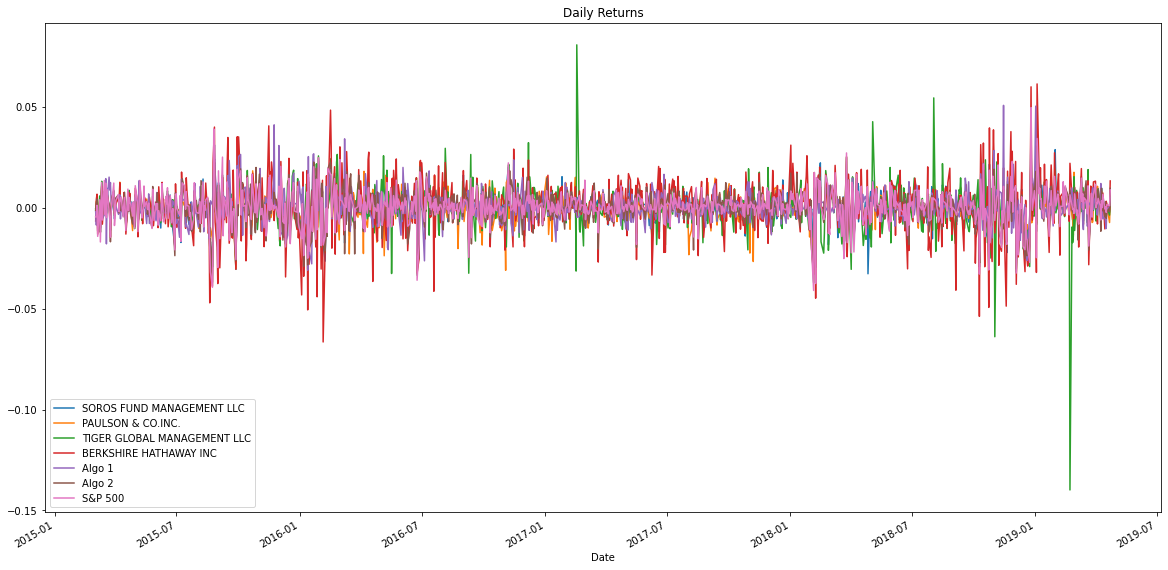

In [137]:
# Plot daily returns
combined_returns.plot(title="Daily Returns", figsize=(20,10))

&lt;AxesSubplot:title={&#39;center&#39;:&#39;Cumulative Returns&#39;}, xlabel=&#39;Date&#39;&gt;

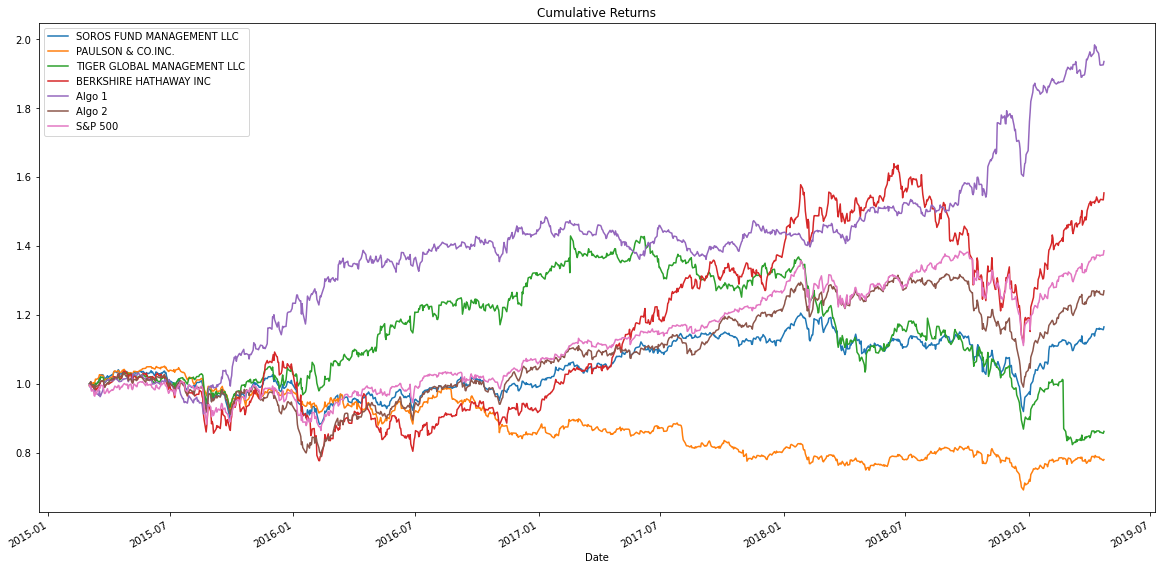

In [138]:
# Plot cumulative returns
cumulative_returns = (1 + combined_returns).cumprod()
cumulative_returns.plot(title="Cumulative Returns", figsize=(20,10))

### *Algo 1 out performed the S&P 500.


## Risk

Determine the _risk_ of each portfolio:

1. Create a box plot for each portfolio. 
2. Calculate the standard deviation for all portfolios
4. Determine which portfolios are riskier than the S&P 500
5. Calculate the Annualized Standard Deviation

&lt;AxesSubplot:&gt;

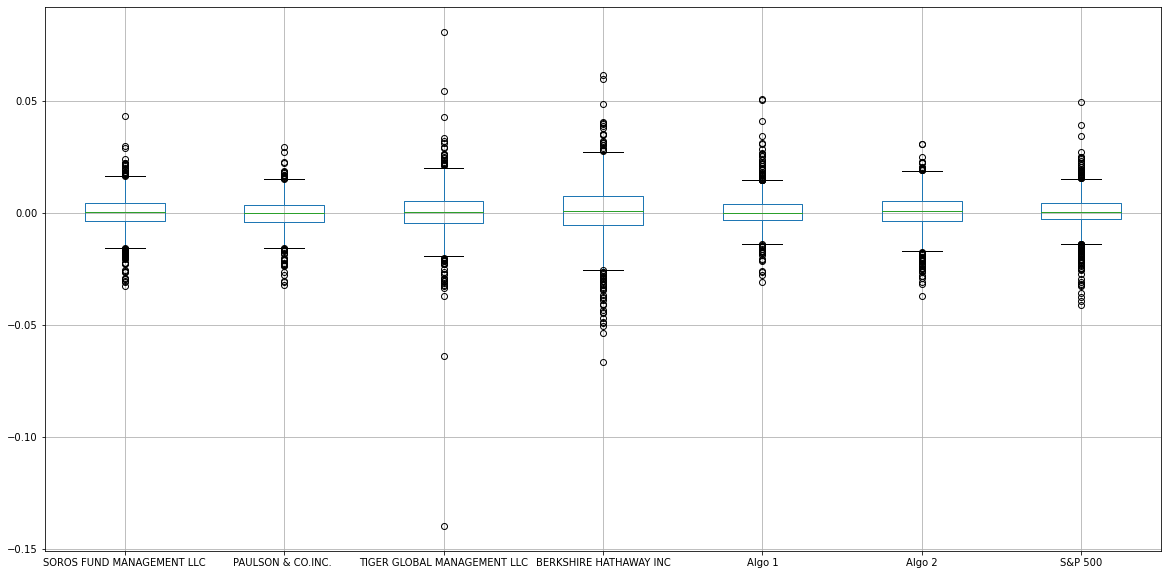

In [139]:
# Box plot to visually show risk
combined_returns.boxplot(figsize=(20,10))


In [143]:
# Daily Standard Deviations
# Calculate the standard deviation for each portfolio. 
# Which portfolios are riskier than the S&P 500?
combined_daily_std = combined_returns.std()
combined_daily_std

SOROS FUND MANAGEMENT LLC      0.007895
PAULSON &amp; CO.INC.              0.007023
TIGER GLOBAL MANAGEMENT LLC    0.010894
BERKSHIRE HATHAWAY INC         0.012919
Algo 1                         0.007620
Algo 2                         0.008342
S&amp;P 500                        0.008554
dtype: float64

### *Tiger Global Management LLC and Berkshire Hathaway Inc have greater risk compared to the S&P 500.

In [175]:
# Determine which portfolios are riskier than the S&P 500
index_num = 0
for portfolio in combined_daily_std:
    if portfolio > combined_daily_std["S&P 500"]:
        true_false = "True"
        print(f"{combined_daily_std.index[index_num]:<30}{true_false:>6}")
    else:
        true_false = "False"
        print(f"{combined_daily_std.index[index_num]:<30}{true_false:>6}")
    index_num += 1

SOROS FUND MANAGEMENT LLC      False
PAULSON &amp; CO.INC.              False
TIGER GLOBAL MANAGEMENT LLC     True
BERKSHIRE HATHAWAY INC          True
Algo 1                         False
Algo 2                         False
S&amp;P 500                        False


In [176]:
# Calculate the annualized standard deviation (252 trading days)
annualized_combined_std = combined_daily_std * np.sqrt(252)
annualized_combined_std

SOROS FUND MANAGEMENT LLC      0.125335
PAULSON &amp; CO.INC.              0.111488
TIGER GLOBAL MANAGEMENT LLC    0.172936
BERKSHIRE HATHAWAY INC         0.205077
Algo 1                         0.120967
Algo 2                         0.132430
S&amp;P 500                        0.135786
dtype: float64

---

## Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

1. Plot the rolling standard deviation of the various portfolios along with the rolling standard deviation of the S&P 500 (consider a 21 day window). Does the risk increase for each of the portfolios at the same time risk increases in the S&P?
2. Construct a correlation table for the algorithmic, whale, and S&P 500 returns. Which returns most closely mimic the S&P?
3. Choose one portfolio and plot a rolling beta between that portfolio's returns and S&P 500 returns. Does the portfolio seem sensitive to movements in the S&P 500?
4. An alternative way to calculate a rolling window is to take the exponentially weighted moving average. This is like a moving window average, but it assigns greater importance to more recent observations. Try calculating the ewm with a 21 day half-life.

&lt;AxesSubplot:title={&#39;center&#39;:&#39;21 Day Rolling Standard Deviation&#39;}, xlabel=&#39;Date&#39;&gt;

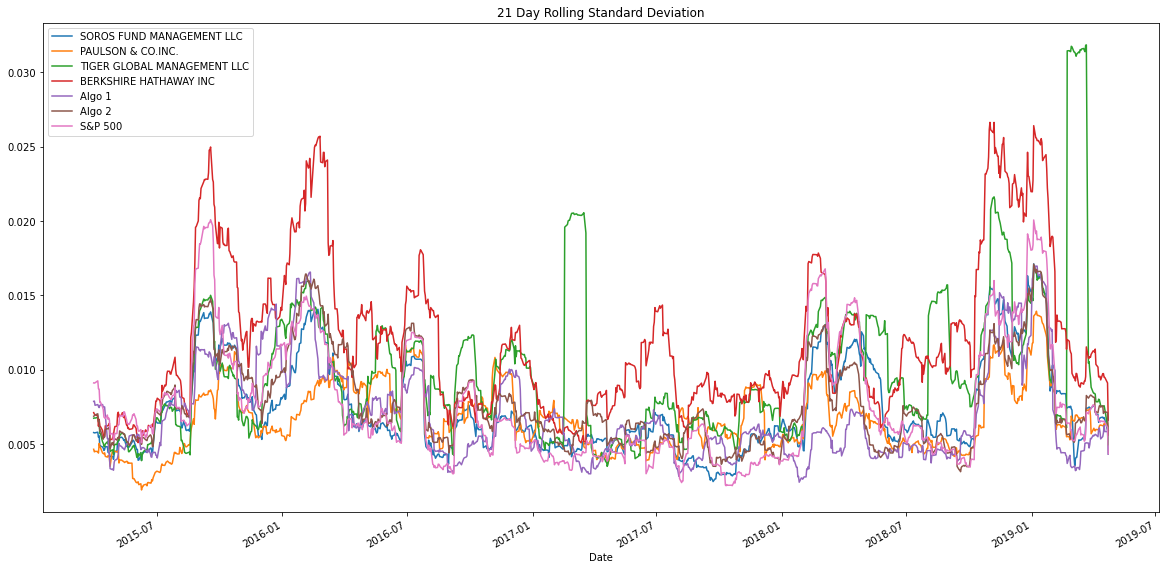

In [183]:
# Calculate and plot the rolling standard deviation for
# the S&P 500 and whale portfolios using a 21 trading day window
combined_returns.rolling(window=21).std().plot(figsize=(20,10), title="21 Day Rolling Standard Deviation")

In [23]:
# Construct a correlation table
# YOUR CODE HERE

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P 500
SOROS FUND MANAGEMENT LLC,1,0.699914,0.561243,0.75436,0.321211,0.826873,0.837864
PAULSON & CO.INC.,0.699914,1,0.434479,0.545623,0.26884,0.678152,0.669732
TIGER GLOBAL MANAGEMENT LLC,0.561243,0.434479,1,0.424423,0.164387,0.507414,0.623946
BERKSHIRE HATHAWAY INC,0.75436,0.545623,0.424423,1,0.292033,0.688082,0.751371
Algo 1,0.321211,0.26884,0.164387,0.292033,1,0.288243,0.279494
Algo 2,0.826873,0.678152,0.507414,0.688082,0.288243,1,0.858764
S&P 500,0.837864,0.669732,0.623946,0.751371,0.279494,0.858764,1


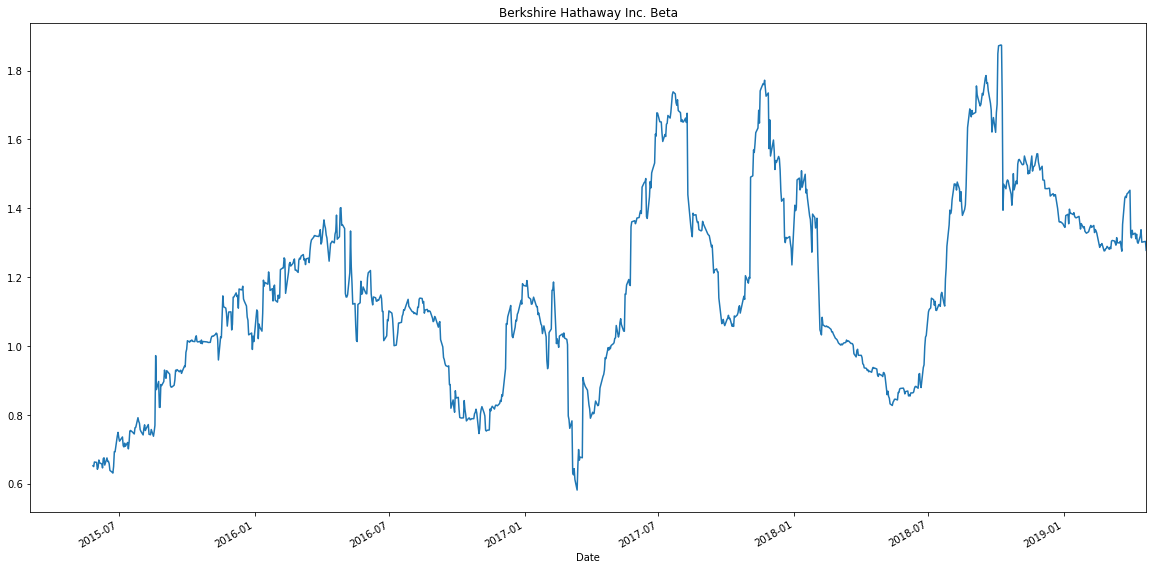

In [24]:
# Calculate Beta for a single portfolio compared to the total market (S&P 500)
# (Your graph may differ, dependent upon which portfolio you are comparing)
# YOUR CODE HERE

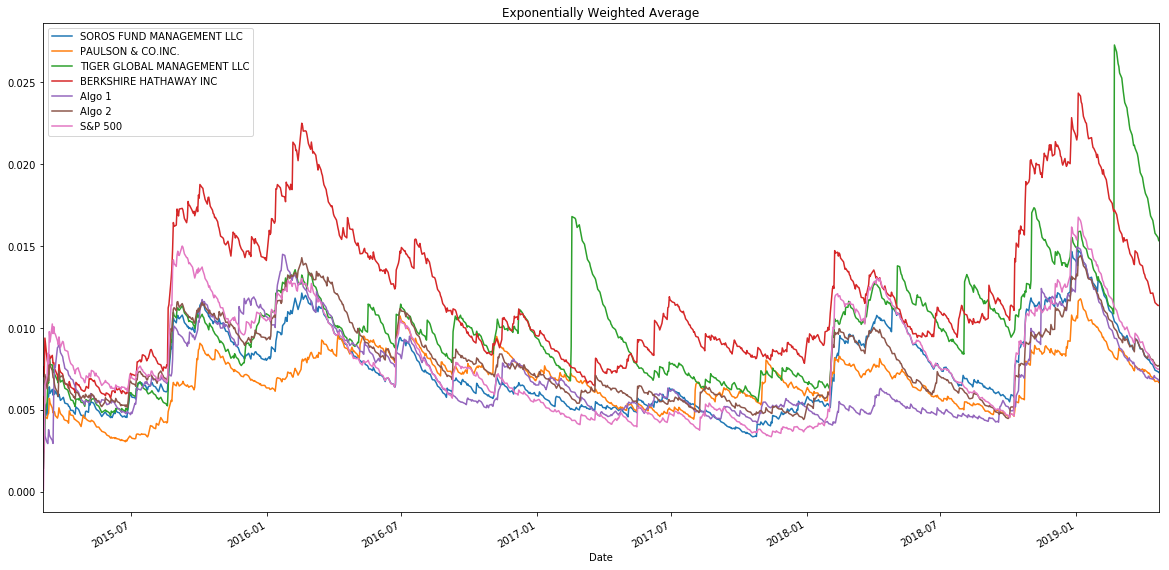

In [25]:
# Calculate a rolling window using the exponentially weighted moving average. 
# YOUR CODE HERE

---

## Sharpe Ratios
In reality, investment managers and thier institutional investors look at the ratio of return-to-risk, and not just returns alone. (After all, if you could invest in one of two portfolios, each offered the same 10% return, yet one offered lower risk, you'd take that one, right?)

1. Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot.
2. Determine whether the algorithmic strategies outperform both the market (S&P 500) and the whales portfolios.

In [26]:
# Calculate annualized Sharpe Ratios
# YOUR CODE HERE

SOROS FUND MANAGEMENT LLC      0.356417
PAULSON & CO.INC.             -0.483570
TIGER GLOBAL MANAGEMENT LLC   -0.121060
BERKSHIRE HATHAWAY INC         0.621810
Algo 1                         1.378648
Algo 2                         0.501364
S&P 500                        0.648267
dtype: float64

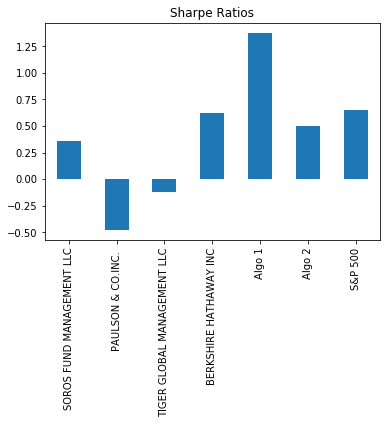

In [27]:
# Visualize the sharpe ratios as a bar plot
# YOUR CODE HERE

On the basis of this performance metric, do our algo strategies outperform both 'the market' and the whales? Type your answer here:

---

# Portfolio Returns

In this section, you will build your own portfolio of stocks, calculate the returns, and compare the results to the Whale Portfolios and the S&P 500. 

1. Visit [Google Sheets](https://docs.google.com/spreadsheets/) and use the in-built Google Finance function to choose 3-5 stocks for your own portfolio.
2. Download the data as CSV files and calculate the portfolio returns.
3. Calculate the returns for each stock.
4. Using those returns, calculate the weighted returns for your entire portfolio assuming an equal number of shares for each stock.
5. Add your portfolio returns to the DataFrame with the other portfolios and rerun the analysis. How does your portfolio fair?


## Your analysis should include the following:

- Using all portfolios:
 - The annualized standard deviation (252 trading days) for all portfolios.
 - The plotted rolling standard deviation using a 21 trading day window for all portfolios.
 - The calculated annualized Sharpe Ratios and the accompanying bar plot visualization.
 - A correlation table.
- Using your custom portfolio and one other of your choosing:
 - The plotted beta. 

## Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.

In [28]:
# Read the first stock
# YOUR CODE HERE

,Symbol,NOCP
Trade DATE,,
2018-05-11,GOOG,1098.26
2018-05-14,GOOG,1100.20
2018-05-15,GOOG,1079.23
2018-05-16,GOOG,1081.77
2018-05-17,GOOG,1078.59


In [29]:
# Read the second stock
# YOUR CODE HERE

,Symbol,NOCP
Trade DATE,,
2018-05-11,AAPL,188.59
2018-05-14,AAPL,188.15
2018-05-15,AAPL,186.44
2018-05-16,AAPL,188.18
2018-05-17,AAPL,186.99


In [30]:
# Read the third stock
# YOUR CODE HERE

,Symbol,NOCP
Trade DATE,,
2018-05-11,COST,195.76
2018-05-14,COST,195.88
2018-05-15,COST,195.48
2018-05-16,COST,198.71
2018-05-17,COST,199.60


In [31]:
# Concatenate all stocks into a single DataFrame
# YOUR CODE HERE

,Symbol,NOCP
Trade DATE,,
2018-05-11,GOOG,1098.26
2018-05-14,GOOG,1100.20
2018-05-15,GOOG,1079.23
2018-05-16,GOOG,1081.77
2018-05-17,GOOG,1078.59


In [32]:
# Reset the index
# YOUR CODE HERE

,Trade DATE,Symbol,NOCP
0,2018-05-11,GOOG,1098.26
1,2018-05-14,GOOG,1100.20
2,2018-05-15,GOOG,1079.23
3,2018-05-16,GOOG,1081.77
4,2018-05-17,GOOG,1078.59


In [33]:
# Pivot so that each column of prices represents a unique symbol
# YOUR CODE HERE

Symbol,AAPL,COST,GOOG
Trade DATE,,,
2018-05-11,188.59,195.76,1098.26
2018-05-14,188.15,195.88,1100.20
2018-05-15,186.44,195.48,1079.23
2018-05-16,188.18,198.71,1081.77
2018-05-17,186.99,199.60,1078.59


In [34]:
# Drop Nulls
# YOUR CODE HERE

Symbol,AAPL,COST,GOOG
Trade DATE,,,
2018-05-14,-0.002333,0.000613,0.001766
2018-05-15,-0.009088,-0.002042,-0.019060
2018-05-16,0.009333,0.016523,0.002354
2018-05-17,-0.006324,0.004479,-0.002940
2018-05-18,-0.003637,-0.003206,-0.011339


## Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock

In [35]:
# Calculate weighted portfolio returns
weights = [1/3, 1/3, 1/3]
# YOUR CODE HERE

Trade DATE
2018-05-14    0.000015
2018-05-15   -0.010064
2018-05-16    0.009403
2018-05-17   -0.001595
2018-05-18   -0.006061
dtype: float64

## Join your portfolio returns to the DataFrame that contains all of the portfolio returns

In [36]:
# Add your "Custom" portfolio to the larger dataframe of fund returns
# YOUR CODE HERE

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P 500,Custom
Date,,,,,,,,
2019-04-16,0.002699,0.000388,-0.000831,0.000837,-0.006945,0.002899,0.000509,0.000340
2019-04-17,-0.002897,-0.006467,-0.004409,0.003222,-0.010301,-0.005228,-0.002274,0.009292
2019-04-18,0.001448,0.001222,0.000582,0.001916,-0.000588,-0.001229,0.001579,0.001545
2019-04-22,-0.002586,-0.007333,-0.003640,-0.001088,0.000677,-0.001936,0.001012,0.001217
2019-04-23,0.007167,0.003485,0.006472,0.013278,0.004969,0.009622,0.008841,0.011959


In [37]:
# Only compare dates where return data exists for all the stocks (drop NaNs)
# YOUR CODE HERE

## Re-run the performance and risk analysis with your portfolio to see how it compares to the others

In [38]:
# Risk
# YOUR CODE HERE

SOROS FUND MANAGEMENT LLC      0.146675
PAULSON & CO.INC.              0.116732
TIGER GLOBAL MANAGEMENT LLC    0.232531
BERKSHIRE HATHAWAY INC         0.247155
Algo 1                         0.133704
Algo 2                         0.139556
S&P 500                        0.152054
Custom                         0.211496
dtype: float64

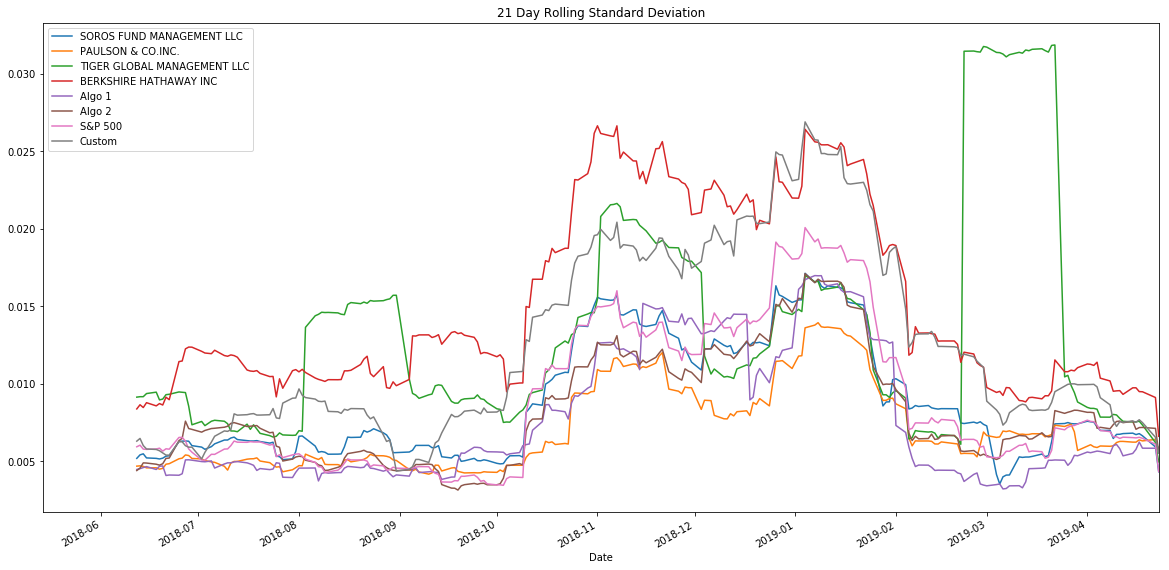

In [39]:
# Rolling
# YOUR CODE HERE

In [40]:
# Annualized Sharpe Ratios
# YOUR CODE HERE

SOROS FUND MANAGEMENT LLC      0.430713
PAULSON & CO.INC.              0.258738
TIGER GLOBAL MANAGEMENT LLC   -1.034216
BERKSHIRE HATHAWAY INC         0.159756
Algo 1                         2.035665
Algo 2                         0.080607
S&P 500                        0.584820
Custom                         0.933123
dtype: float64

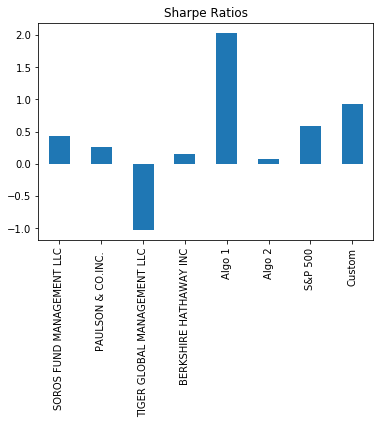

In [41]:
# Visualize the sharpe ratios as a bar plot
# YOUR CODE HERE

In [42]:
# Create a correlation analysis
# YOUR CODE HERE

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P 500,Custom
SOROS FUND MANAGEMENT LLC,1,0.791962,0.478627,0.816675,0.337826,0.862846,0.876981,0.73325
PAULSON & CO.INC.,0.791962,1,0.485375,0.650758,0.361301,0.783656,0.76668,0.64421
TIGER GLOBAL MANAGEMENT LLC,0.478627,0.485375,1,0.325457,0.114554,0.409496,0.48103,0.391972
BERKSHIRE HATHAWAY INC,0.816675,0.650758,0.325457,1,0.327,0.782804,0.852303,0.801158
Algo 1,0.337826,0.361301,0.114554,0.327,1,0.365512,0.289358,0.261471
Algo 2,0.862846,0.783656,0.409496,0.782804,0.365512,1,0.875721,0.739936
S&P 500,0.876981,0.76668,0.48103,0.852303,0.289358,0.875721,1,0.871875
Custom,0.73325,0.64421,0.391972,0.801158,0.261471,0.739936,0.871875,1


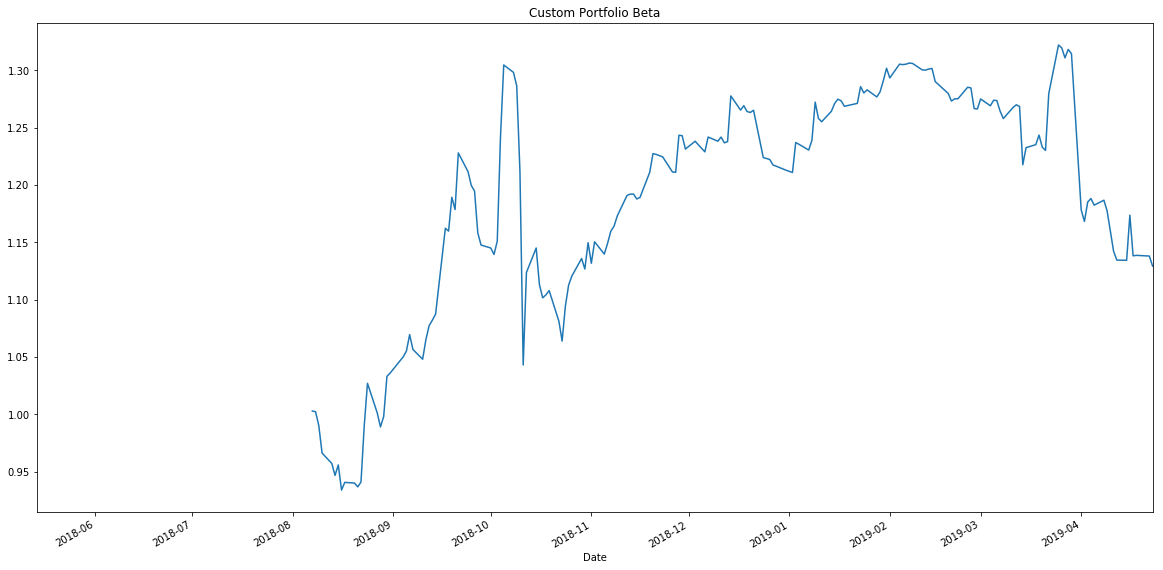

In [43]:
# Beta
# YOUR CODE HERE